<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#J1-J2模型" data-toc-modified-id="J1-J2模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>J1-J2模型</a></span></li><li><span><a href="#格点MPO" data-toc-modified-id="格点MPO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>格点MPO</a></span></li><li><span><a href="#MPS正则表示" data-toc-modified-id="MPS正则表示-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MPS正则表示</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#确定边界" data-toc-modified-id="确定边界-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>确定边界</a></span></li><li><span><a href="#能量期望值" data-toc-modified-id="能量期望值-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>能量期望值</a></span></li><li><span><a href="#VUMPS" data-toc-modified-id="VUMPS-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>VUMPS</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#程序检验" data-toc-modified-id="程序检验-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>程序检验</a></span><ul class="toc-item"><li><span><a href="#bond强度比例-r" data-toc-modified-id="bond强度比例-r-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>bond强度比例 r</a></span></li><li><span><a href="#温度-β" data-toc-modified-id="温度-β-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>温度 β</a></span></li></ul></li><li><span><a href="#待解决问题" data-toc-modified-id="待解决问题-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><font color="Red">待解决问题</font></a></span><ul class="toc-item"><li><span><a href="#快速迭代得到$L1，L2$时不收敛" data-toc-modified-id="快速迭代得到$L1，L2$时不收敛-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>快速迭代得到$L1，L2$时不收敛</a></span></li><li><span><a href="#r-=-1.01~1.1之间时能量不能极小化" data-toc-modified-id="r-=-1.01~1.1之间时能量不能极小化-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>r = 1.01~1.1之间时能量不能极小化</a></span></li></ul></li></ul></div>

## J1-J2模型 
横向连接耦合强度为$J_1,J_2$交替排布，纵向全为$J_1$
<img src="figure/1.png" width="50%">

## 格点MPO
权重张量为$M1,M2$
<img src="figure/2.png" width="50%">
红色连接上张量为
$\exp(-J_2 h_{ij})$, $J_2 = r J_1$

要收缩的目标张量Z2为
<img src="figure/6.png" width="25%">

能量权重张量为$ME1,ME2$
<img src="figure/3.png" width="50%">

In [1]:
# call library
using LinearAlgebra, TensorOperations, KrylovKit, Random, Statistics

In [2]:
# define M1,M2,ME1,ME1
function statmechmpo(β, h, D; r = 2.0)
    I = zeros(D,D,D,D)
    for i = 1:D
        I[i,i,i,i] = 1
    end
 
    X1 = zeros(D,D)
    for j = 1:D, i = 1:D
        X1[i,j] = exp(-β*h(i,j))
    end

    X2 = zeros(D,D)
    for j = 1:D, i = 1:D
        X2[i,j] = exp(-β*r*h(i,j))
    end

    X1sq = sqrt(X1)
    X2sq = sqrt(X2)

    @tensor M1[a,b,c,d] := I[a',b',c',d']*X2sq[c',c]*X1sq[d',d]*X1sq[a',a]*X1sq[b',b]
    M2 = permutedims(M1,[3,2,1,4])

    # For computing energy: M2 is a tensor across 2 nearest neighbor sites in the lattice, whose
    # expectation value in the converged fixed point of the transfer matrix represents the energy
    Y1 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y1[i,j] = h(i,j)*exp(-β*h(i,j))
    end
    Y2 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y2[i,j] = r*h(i,j)*exp(-β*r*h(i,j))
    end

    @tensor ME1[a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X2sq[a,a']*X1sq[b1,b1']*X1sq[d1',d1]* Y1[c1,c2]*
                                    I[c2,b2',c',d2']*X1sq[b2,b2']*X1sq[d2',d2]*X2sq[c',c]
    @tensor ME2[a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X1sq[a,a']*X1sq[b1,b1']*X1sq[d1',d1]* Y2[c1,c2]*
                                    I[c2,b2',c',d2']*X1sq[b2,b2']*X1sq[d2',d2]*X1sq[c',c]
    return M1, M2, ME1, ME2
end

classicalisingmpo(β; J = 1.0, h = 0.,r = 1.0) = statmechmpo(β, (s1,s2)->-J*(-1)^(s1!=s2) - h/2*(s1==1 + s2==1),
                                                                                            2;r)

classicalisingmpo (generic function with 1 method)

In [3]:
#test
βc = log(1+sqrt(2))/2
β = 0.95*βc
M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0)
@show norm(M1.-M2) norm(ME1.-ME2)

norm(M1 .- M2) = 1.8410966031475738e-16
norm(ME1 .- ME2) = 0.0


0.0

## MPS正则表示
### 单格点
对于Uniform MPS，在归一化时，边界收缩为
<img src="figure/4.png" width="50%">
从而引入左右正则张量$AL$和$AR$：
<img src="figure/5.png" width="30%">
使得边界收缩掉
<img src="figure/7.png" width="30%">
具体做法为在$A$张量间，左边插入$L^{-1}L$，右边边插入$L^{-1}L$，然后根据周期不变性得到红色方框中的相等的变换关系
<img src="figure/8.png" width="50%">

### J1-J2
对于A1-A2 MPS，在归一化时，边界收缩为
<img src="figure/9.png" width="40%">
同样引入左正则表示
<img src="figure/10.png" width="40%">
将Uniform形式变换为正则表示，左边插入$L1^{-1}L1L2^{-1}L2$，右边插入$R1R1^{-1}R2R2^{-1}$
<img src="figure/11.png" width="100%">
不同于Uniform形式，$AL1$和$AL2$间多了$L1L2^{-1}$，$AL1$和$AL2$间多了$R1^{-1}R2$，为了收缩能够继续，必须要求
<img src="figure/12.png" width="50%">

In [4]:
# function to get AL1,AL2 and AR1,AR2
safesign(x::Number) = iszero(x) ? one(x) : sign(x)

"""
    qrpos(A)

Returns a QR decomposition, i.e. an isometric `Q` and upper triangular `R` matrix, where `R`
is guaranteed to have positive diagonal elements.
"""
qrpos(A) = qrpos!(copy(A))
function qrpos!(A)
    F = qr!(A)
    Q = Matrix(F.Q)
    R = F.R
    phases = safesign.(diag(R))
    rmul!(Q, Diagonal(phases))
    lmul!(Diagonal(conj!(phases)), R)
    return Q, R
end

"""
    lqpos(A)

Returns a LQ decomposition, i.e. a lower triangular `L` and isometric `Q` matrix, where `L`
is guaranteed to have positive diagonal elements.
"""
lqpos(A) = lqpos!(copy(A))
function lqpos!(A)
    F = qr!(Matrix(A'))
    Q = Matrix(Matrix(F.Q)')
    L = Matrix(F.R')
    phases = safesign.(diag(L))
    lmul!(Diagonal(phases), Q)
    rmul!(L, Diagonal(conj!(phases)))
    return L, Q
end

function ρmap(ρ,A1,A2)
    @tensor ρ1[a,b] := ρ[a',b']*A1[b',s,b]*conj(A1[a',s,a])
    @tensor ρ2[a,b] := ρ1[a',b']*A2[b',s,b]*conj(A2[a',s,a])
    return ρ2
end
        
"""
    getL(ρ; kwargs...)
    ┌ A1─A2─    ┌       L ─
    ρ │  │    = ρ   =  │
    ┕ A1─A2─    ┕       L'─
ρ=L'*L, return L, where `L`is guaranteed to have positive diagonal elements.
L = cholesky!(ρ).U
If ρ is not exactly positive definite, cholesky will fail
"""
function getL!(L,A1,A2)
    λs,ρs,_ = eigsolve(ρ->ρmap(ρ,A1,A2),L'*L, 1, :LM; ishermitian = false, tol = 1e-12, maxiter = 1)
#     ρ2 = ρmap(ρs[1],A1,A2)
#     @show norm(ρ2.-ρs[1]*λs[1])
    ρ = ρs[1] + ρs[1]'
    ρ ./= tr(ρ)
    F = svd!(ρ)
    L = lmul!(Diagonal(sqrt.(F.S)), F.Vt)
    _, L = qrpos!(L)
    return L
end

"""
    getAL(A)

Given an MPS tensor `A` and `L` ，return a left-canonical MPS tensor `AL`, a gauge transform `R` and
a scalar factor `λ` such that ``λ AR R = L A``
"""
function getAL(A,L1,L2)
    D, d, = size(A) 
    Q, R = qrpos!(reshape(L1*reshape(A, D, d*D), D*d, D))
    AL = reshape(Q, D, d, D)
    @tensor AL[a,s,b] := AL[a,s,d1] * L2[d1,d2] * (L1^-1)[d2,b]
    R = L1 * L2^-1 * R
    λ = norm(R)
    rmul!(R, 1/λ)
#     @tensor X1[a,s,b] := AL[a,s,d] * R[d,b] * λ
#     @tensor X2[a,s,b] := L1[a,d] * A[d,s,b]
#     @show norm(X1.-X2)
    return AL, R, λ
end

function Lmap(L1, L2, A1, A2, AL1, AL2)
#     @tensor X1[a,b] := L[d1,d2] * A1[d2,s,b] * conj(AL1[d1,s,d3] * L[d3,a])
#     @tensor X2[a,b] := X1[d1,d2] * A2[d2,s,b] * conj(A2[d1,s,d3] * (L^-1)[d3,a])
#     @tensor X[a,b] := L1[d1,d2] * A1[d2, s, d4] * (L2^-1)[d4, d6] * L1[d6, b] *
#                 conj(AL[d1, s, d3] * L1[d3, d5] * (L2^-1)[d5,a])
    @tensor X1[a,b] := L1[d1,d2] * A1[d2,s,b] * conj(AL1[d1,s,d3] * L1[d3,d4] * (L2^-1)[d4, a])
    @tensor X2[a,b] := X1[d1,d2] * A2[d2,s,b] * conj(AL2[d1,s,d3] * L2[d3,d4] * (L1^-1)[d4, a])
    return X2
end

function getLsped(R1, R2, A1, A2, AL1, AL2)
    # L = R
    λs, Ls, _ = eigsolve(L->Lmap(L, R2, A1, A2, AL1, AL2), R1, 1, :LM; ishermitian = false, tol = 1e-12, maxiter = 1)
#     Lm = Lmap(Ls[1],A1,A2,AL1,AL2)
#     @show norm(Lm.-Ls[1]*λs[1])
    _, L = qrpos!(Ls[1])
    return L
end

"""
    leftorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a left-canonical MPS tensor `AL`, a gauge transform `C` and
a scalar factor `λ` such that ``λ AL L = L A``, where an initial guess for `C` can be
provided.
"""
function leftorth(A1, A2, L1 = Matrix{eltype(A1)}(I, size(A1,1), size(A1,1)),
                    L2 = Matrix{eltype(A2)}(I, size(A2,1), size(A2,1)); tol = 1e-12, maxiter = 200, kwargs...)
    L1 = getL!(L1,A1,A2)
    L2 = getL!(L2,A2,A1)
#     @tensor AL1[a,s,b] := L1[a,d1] * A1[d1,s,d2] * (L1^-1)[d2,b]
#     @tensor AL2[a,s,b] := L2[a,d1] * A2[d1,s,d2] * (L2^-1)[d2,b]
    AL1,R1,λ1 = getAL(A1,L1,L2)
    AL2,R2,λ2 = getAL(A2,L2,L1)
    
    numiter = 1
    while norm(L1.-R1) + norm(L2.-R2) > tol*2 && numiter < maxiter
        L1 = getL!(R1,A1,A2)
        L2 = getL!(R2,A2,A1)
#         L1 = getLsped(R1, R2, A1, A2, AL1, AL2)
#         L2 = getLsped(R2, R1, A2, A1, AL2, AL1)
        AL1,R1,λ1 = getAL(A1,L1,L2)
        AL2,R2,λ2 = getAL(A2,L2,L1)
        numiter += 1
    end
    L1 = R1
    L2 = R2
    return AL1, AL2, L1, L2, numiter
end

"""
    rightorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a gauge transform C, a right-canonical MPS tensor `AR`, and
a scalar factor `λ` such that ``λ C AR^s = A^s C``, where an initial guess for `C` can be
provided.
"""
function rightorth(A1, A2, L1 = Matrix{eltype(A1)}(I, size(A1,1), size(A1,1)),
                    L2 = Matrix{eltype(A2)}(I, size(A2,1), size(A2,1)); tol = 1e-12, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(permutedims(A1,(3,2,1)), permutedims(A2,(3,2,1)), permutedims(L1,(2,1)), permutedims(L2,(2,1)); tol = tol, kwargs...)
    R1 = permutedims(L1,(2,1))
    R2 = permutedims(L2,(2,1))
    AR1 = permutedims(AL1,(3,2,1))
    AR2 = permutedims(AL2,(3,2,1))
    return R1, R2, AR1, AR2, numiter
end

rightorth

In [5]:
# test
D = 50
Random.seed!(1234)
A1 = randn(D, 2, D) + im*randn(D, 2, D)
Random.seed!(1234)
A2 = randn(D, 2, D) + im*randn(D, 2, D)
AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)
L1_2 = ρmap(L1' * L1, A1, A2)
@show std(L1_2./(L1' * L1))

ρL1 = (L1^-1)' * L2' * L2 * (L1^-1)
ρL2 = (L2^-1)' * L1' * L1 * (L2^-1)
@tensor AL1_2[a,b] := AL1[d,s,b] * conj(AL1[d,s,a])
@tensor AL2_2[a,b] := AL2[d,s,b] * conj(AL2[d,s,a])
@show norm(AL1_2.-ρL1), norm(AL2_2.-ρL2)

ρR1 =  (R1^-1) * R2 * R2' * (R1^-1)' 
ρR2 =  (R2^-1) * R1 * R1' * (R2^-1)'
@tensor AR1_2[a,b] := AR1[a,s,d] * conj(AR1[b,s,d])
@tensor AR2_2[a,b] := AR2[a,s,d] * conj(AR2[b,s,d])
@show norm(AR1_2.-ρR1), norm(AR2_2.-ρR2) norm(A1.- A2) norm(AL1.- AL2)
numiter

std(L1_2 ./ (L1' * L1)) = 4.85641139021739e-10
(norm(AL1_2 .- ρL1), norm(AL2_2 .- ρL2)) = (6.620347251356154e-15, 6.620347251356154e-15)
(norm(AR1_2 .- ρR1), norm(AR2_2 .- ρR2)) = (1.2017726483998582e-14, 1.2017726483998582e-14)
norm(A1 .- A2) = 0.0
norm(AL1 .- AL2) = 0.0


2

## 确定边界
<img src="figure/13.png" width="50%">

In [6]:
# function to get FL1 ,FL2 and FR1,FR2
function FLmap(AL1, AL2, M1, M2, FL)
    @tensor X1[α,a,β] := FL[α',a',β']*AL1[β',s',β]*M1[a',s,a,s']*conj(AL1[α',s,α])
    @tensor X2[α,a,β] := X1[α',a',β']*AL2[β',s',β]*M2[a',s,a,s']*conj(AL2[α',s,α])
    return X2
end

function FRmap(AR1, AR2, M1, M2, FR)
    @tensor X1[α,a,β] := AR1[α,s',α']*FR[α',a',β']*M1[a,s,a',s']*conj(AR1[β,s,β'])
    @tensor X2[α,a,β] := AR2[α,s',α']*X1[α',a',β']*M2[a,s,a',s']*conj(AR2[β,s,β'])
    return X2
end
    
"""
    leftenv(A, M, FL; kwargs)

Compute the left environment tensor for MPS A and MPO M, by finding the left fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function leftenv(AL1, AL2, M1, M2, FL = randn(eltype(AL1), size(AL1,1), size(M1,1), size(AL1,1)); kwargs...)
    λ1s, FL1s, = eigsolve(X->FLmap(AL1, AL2, M1, M2, X), FL, 1, :LM; ishermitian = false, kwargs...)
    λ2s, FL2s, = eigsolve(X->FLmap(AL2, AL1, M2, M1, X), FL1s[1], 1, :LM; ishermitian = false, kwargs...)
    return FL1s[1], FL2s[1], real(λ1s[1]), real(λ2s[1])
end
"""
    rightenv(A, M, FR; kwargs...)

Compute the right environment tensor for MPS A and MPO M, by finding the right fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function rightenv(AR1, AR2, M1, M2, FR = randn(eltype(AR1), size(AR1,1), size(M1,1), size(AR1,1)); kwargs...)
    λ1s, FR1s, = eigsolve(X->FRmap(AR1, AR2, M1, M2, X), FR, 1, :LM; ishermitian = false, kwargs...)
    λ2s, FR2s, = eigsolve(X->FRmap(AR2, AR1, M2, M1, X), FR1s[1], 1, :LM; ishermitian = false, kwargs...)
    return FR1s[1], FR2s[1], real(λ1s[1]), real(λ2s[1])
end

rightenv

In [7]:
# test
FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
X1 = FLmap(AL1, AL2, M1, M2, FL1)
X2 = FLmap(AL2, AL1, M2, M1, FL2)
X3 = FRmap(AR1, AR2, M1, M2, FR1)
X4 = FRmap(AR2, AR1, M2, M1, FR2)

@tensor X5[α,a,β] := FL1[α',a',β']*AL1[β',s',β]*M1[a',s,a,s']*conj(AL1[α',s,α])
@show norm(X1.- FL1*λL1) norm(X2.- FL2*λL2) norm(X3.- FR1*λR1) norm(X4.- FR2*λR2) 
@show norm(FL1.- FL2) norm(FR1.- FR2)
@show std(X5./FL2)

norm(X1 .- FL1 * λL1) = 1.014622945059134e-13
norm(X2 .- FL2 * λL2) = 1.0004353575932725e-13
norm(X3 .- FR1 * λR1) = 1.0000061875147943e-13
norm(X4 .- FR2 * λR2) = 9.828853461198515e-14
norm(FL1 .- FL2) = 3.553986221805388e-15
norm(FR1 .- FR2) = 6.645852815597634e-16
std(X5 ./ FL2) = 8.092694290413157e-13


8.092694290413157e-13

## 能量期望值
<img src="figure/15.png" width="50%">

In [8]:
# function to get energy
function energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @tensor AAC1[α,s1,s2,β] := AL1[α,s1,α']*C1[α',β']*AR2[β',s2,β]
    @tensor AAC2[α,s1,s2,β] := AL2[α,s1,α']*C2[α',β']*AR1[β',s2,β]
    @tensor Z21 = scalar(FL1[α,c,β]*AAC1[β,s1,s2,β']*M1[c,t1,d,s1]*
        M2[d,t2,c',s2]*FR2[β',c',α']*conj(AAC1[α,t1,t2,α']))
    @tensor Z22 = scalar(FL2[α,c,β]*AAC2[β,s1,s2,β']*M2[c,t1,d,s1]*
        M1[d,t2,c',s2]*FR1[β',c',α']*conj(AAC2[α,t1,t2,α']))
#     @show Z21 Z22
    @tensor e2 = scalar(FL1[α,c,β]*AAC1[β,s1,s2,β']*ME2[c,t1,t2,c',s2,s1]*
        FR2[β',c',α']*conj(AAC1[α,t1,t2,α']) / Z21)
    @tensor e1 = scalar(FL2[α,c,β]*AAC2[β,s1,s2,β']*ME1[c,t1,t2,c',s2,s1]*
        FR1[β',c',α']*conj(AAC2[α,t1,t2,α']) / Z22)
    return (e1+e2)/2
end

energy (generic function with 1 method)

In [9]:
#test
C1 = L1 * R2
C2 = L2 * R1
e = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
@show e

e = -0.38312092955518234 + 1.3010426069826053e-16im


-0.38312092955518234 + 1.3010426069826053e-16im

## VUMPS
### 单格点
单格点VUMPS变分极值条件为
<img src="figure/14.png" width="50%">
### J1-J2
定义$C1 = L1 \cdot R2$，$AC1 = AL1\cdot C1$，J1-J2 VUMPS变分极值条件为
<img src="figure/16.png" width="50%">
进一步简化为
<img src="figure/17.png" width="50%">

In [25]:
# vumps
function applyH1(AC, FL, FR, M)
    @tensor HAC[α,s,β] := FL[α,a,α']*AC[α',s',β']*M[a,s,b,s']*FR[β',b,β]
end

function applyH0(C, FL, FR)
    @tensor HC[α,β] := FL[α,a,α']*C[α',β']*FR[β',a,β]
end

"""
    function vumpsstep(AL, C, AR, FL, FR; kwargs...)

Perform one step of the VUMPS algorithm
"""
function vumpsstep(AL,C,FL1,FL2,FR,M;kwargs...)
    D,d, = size(AL)
    @tensor AC[a,s,b] := AL[a,s,c] * C[c, b]
    μACs, ACs, = eigsolve(x->applyH1(x, FL1, FR, M), AC, 1, :LM; ishermitian = false, maxiter = 1, kwargs...)
    μCs, Cs, = eigsolve(x->applyH0(x, FL2, FR), C, 1; ishermitian = false, maxiter = 1, kwargs...)
    λ = real(μACs[1]/μCs[1])
    AC = ACs[1]   
    C = Cs[1]
    
    QAC, RAC = qrpos(reshape(AC,(D*d, D)))
    QC, RC = qrpos(C)
    AL = reshape(QAC*QC', (D, d, D))
    errL = norm(RAC-RC)
    
    LAC, QAC = lqpos(reshape(AC,(D, d*D)))
    LC, QC = lqpos(C)
    AR = reshape(QC'*QAC, (D, d, D))
    errR = norm(LAC-LC)
    
    return λ, AL, C, AR, errL, errR
end

function error(AL,C,FL,FR,M)
    @tensor AC[a,s,b] := AL[a,s,b']*C[b',b]
    MAC = applyH1(AC, FL, FR, M)
    @tensor MAC[a,s,b] -= AL[a,s,b']*(conj(AL[a',s',b'])*MAC[a',s',b])
    err = norm(MAC)
    return err
end
    
function vumps(A1, A2, M1, M2;verbose = true, tol = 1e-6, maxiter = 100, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
    R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)

    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)

    verbose && println("Starting point has λ ≈ $λL1 ≈ $λR1")
    C1 = L1 * R2
    C2 = L2 * R1

    λ1, AL1, C1, AR1, errL1, errR1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
    λ2, AL2, C2, AR2, errL2, errR2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
#     AL1, AL2, C1, C2, numiter = leftorth(AR1, AR2, C1, C2) # regauge MPS: not really necessary
    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#     FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C2[c,c'])*FR1[a',b,c']) # normalize FL and FR: not really necessary

    # Convergence measure: norm of the projection of the residual onto the tangent space
    err1 = error(AL1,C1,FL1,FR1,M1)
    err2 = error(AL2,C2,FL2,FR2,M2)
    i = 1
    verbose && println("Step $i: λ1 ≈ $λ1,λ2≈ $λ2 ,$λL1 ≈ $λL2, λR1 ≈ $λR2,err1 ≈ 
        $err1, err2 ≈ $err2")
    while (err1 > tol || err2 > tol) && i < maxiter
        λ1, AL1, C1, AR1, errL1, errR1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
        λ2, AL2, C2, AR2, errL2, errR2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
        FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
        FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#         FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C2[c,c'])*FR1[a',b,c'])  # normalize FL and FR: not really necessary
        err1 = error(AL1,C1,FL1,FR1,M1)
        err2 = error(AL2,C2,FL2,FR2,M2)
        i += 1
        λL1sq = sqrt(λL1)
        λR2sq = sqrt(λR2)
        verbose && println("Step $i: λ1 ≈ $λ1,λ2≈ $λ2 ,
            $λL1 ≈ $λL2, $λR1 ≈ $λR2,
            err1 ≈ $err1, err2 ≈ $err2")
    end
    return λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2
end

vumps (generic function with 2 methods)

In [26]:
# test expectation 
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = vumps(A1,A2,M1,M2; tol = 1e-6)

e = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
@show e

Starting point has λ ≈ 3.456158845410357 ≈ 3.4561588454102923
Step 1: λ1 ≈ -2.110760489356869,λ2≈ -1.9657974137316714 ,8.497248660776306 ≈ 8.497248660776329, λR1 ≈ 8.303402434349096,err1 ≈ 
        0.020673525325737525, err2 ≈ 0.020154715112975917
Step 2: λ1 ≈ -2.122343295081866,λ2≈ -1.9968423835520148 ,
            8.502910060911447 ≈ 8.502910060911507, 7.644807715132063 ≈ 7.644807715132027,
            err1 ≈ 3.2761472086987605e-5, err2 ≈ 3.155714530376194e-5
Step 3: λ1 ≈ -0.5906029185730094,λ2≈ -0.5619784771096767 ,
            8.502910095254007 ≈ 8.502910095254014, 5.105962627009876 ≈ 5.105962627009911,
            err1 ≈ 9.904267579307974e-7, err2 ≈ 8.046528338481668e-7
e = -1.3522233404837116 + 1.8106176280507924e-16im


-1.3522233404837116 + 1.8106176280507924e-16im

## 程序检验
### bond强度比例 r

In [39]:
#full test change r
βc = log(1+sqrt(2))/2
β = 0.95*βc
e = zeros(10) + im * zeros(10)
for i = 1:10
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0 * i)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end

Starting point has λ ≈ 2.7331901209175045 ≈ 2.7331901209175236
Step 1: λ1 ≈ 2.451839611651781,λ2≈ 2.451839611651774 ,6.029976197305416 ≈ 6.0299761973055155, λR1 ≈ 6.006165348081827,err1 ≈ 
        0.011152032785633998, err2 ≈ 0.011151951306590137
Step 2: λ1 ≈ -2.4179567916182427,λ2≈ -2.4179568903385653 ,
            6.059151138268072 ≈ 6.059151138268082, 6.058259866743528 ≈ 6.058259866743505,
            err1 ≈ 0.0016214407707061385, err2 ≈ 0.001619952509541916
Step 3: λ1 ≈ -2.3486790018775614,λ2≈ -2.3486018343772628 ,
            6.061667576613161 ≈ 6.0616675766131545, 6.061644002537747 ≈ 6.061644002537715,
            err1 ≈ 8.300201545641537e-5, err2 ≈ 8.305922081637905e-5
Step 4: λ1 ≈ -2.3276294313335972,λ2≈ -2.3277400538843587 ,
            6.0616761269128006 ≈ 6.061676126912836, 6.0616754487998445 ≈ 6.061675448799855,
            err1 ≈ 4.7229569423131317e-7, err2 ≈ 4.7356038123512027e-7
e[i] = -0.6084993260887509 + 2.122732328455057e-16im
Starting point has λ ≈ 3.456158845410313

r = 1 ,energy = -0.6084993260887509
r = 2 ,energy = -1.3537720834113314
r = 3 ,energy = -1.9264053651826736
r = 4 ,energy = -2.4479434212126403
r = 5 ,energy = -2.9682652371510785
r = 6 ,energy = -3.477800684685216
r = 7 ,energy = -3.980341636542499
r = 8 ,energy = -4.480693080847579
r = 9 ,energy = -4.982147441144694
r = 10 ,energy = -5.482070786640875


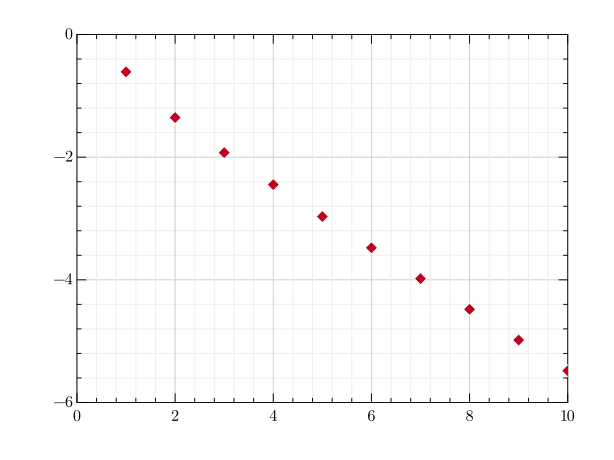

In [40]:
#plot
using GR
x = 1:1:10
xlim([0, 10])
ylim([-6, 0])
for i = 1:1:10
    y = real(e[i])
    println("r = $i ,energy = $y")
end
plot(x, real(e),"red")

### 温度 β

In [48]:
#full test change β
e = zeros(10) + im * zeros(10)
for i = 1:10
    M1, M2, ME1, ME2 = classicalisingmpo(0.1 * i; r = 2)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end

Starting point has λ ≈ 1.2070586119458757 ≈ 1.2070586119459026
Step 1: λ1 ≈ -1.3590724515224712,λ2≈ -1.3305728869799578 ,4.1435139538800385 ≈ 4.143513953879984, λR1 ≈ 4.133039895821785,err1 ≈ 
        0.011955374948782307, err2 ≈ 0.011385229807105076
Step 2: λ1 ≈ -1.3844252436700675,λ2≈ -1.3606729314144832 ,
            4.14389428656611 ≈ 4.143894286566122, 4.082704072414989 ≈ 4.082704072415009,
            err1 ≈ 7.309061112478387e-7, err2 ≈ 7.15563520148381e-7
e[i] = -0.2520964708080865 - 3.9824101048108185e-17im
Starting point has λ ≈ 1.628711706739581 ≈ 1.6287117067395647
Step 1: λ1 ≈ 1.5241078550620921,λ2≈ 1.4571929761334204 ,4.512887701548045 ≈ 4.512887701548037, λR1 ≈ 4.510118321992768,err1 ≈ 
        0.1010808069924861, err2 ≈ 0.10849172803746565
Step 2: λ1 ≈ -0.400660506442042,λ2≈ -0.3819577553124312 ,
            4.626460509968095 ≈ 4.626460509968115, 4.185567831310802 ≈ 4.185567831310793,
            err1 ≈ 0.0002880366480235903, err2 ≈ 0.00035182113174525527
Step 3: λ1 ≈ -0

β = 0.1 ,energy = -0.2520964708080865
β = 0.2 ,energy = -0.5118030602196689
β = 0.3 ,energy = -0.6758413842342361
β = 0.4 ,energy = -1.2434558611555113
β = 0.5 ,energy = -1.442210579628941
β = 0.6 ,energy = -1.481634788550331
β = 0.7 ,energy = -1.4937441972299978
β = 0.8 ,energy = -1.497802851579992
β = 0.9 ,energy = -1.4992133211590644
β = 1.0 ,energy = -1.4997180622908697


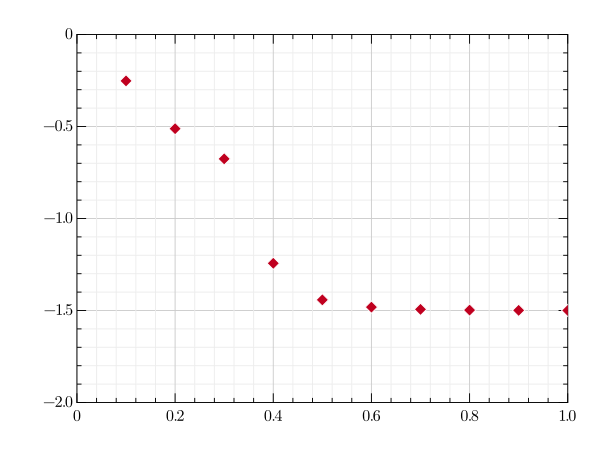

In [54]:
#plot
using GR
x = 0.1:0.1:1.0
xlim([0, 1.0])
ylim([-2, 0])
for i = 1:1:10
    β= i/10
    y = real(e[i])
    println("β = $β ,energy = $y")
end
plot(x, real(e),"red")

## <font color=Red>待解决问题</font> 
### 快速迭代得到$L1，L2$时不收敛
<img src="figure/18.png" width="100%">

### r = 1.01~1.1之间时能量不能极小化

In [41]:
# r = 1.01~1.1
βc = log(1+sqrt(2))/2
β = 0.95*βc
e = zeros(10) + im * zeros(10)
for i = 1:10
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0 + 0.01 * i)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end

Starting point has λ ≈ 2.73775664832731 ≈ 2.737756648327319
Step 1: λ1 ≈ 2.4261628183268114,λ2≈ 2.4233492659063396 ,6.046495277969509 ≈ 6.0464952779694325, λR1 ≈ 6.022472295963813,err1 ≈ 
        0.011123938092035244, err2 ≈ 0.01110061981723978
Step 2: λ1 ≈ 0.47931762916820775,λ2≈ 0.478847916658468 ,
            6.074472162309875 ≈ 6.074472162309863, 6.068827650013106 ≈ 6.068827650013136,
            err1 ≈ 0.0016818459345238458, err2 ≈ 0.0016565724759423674
Step 3: λ1 ≈ 2.400632004965648,λ2≈ 2.398519102830579 ,
            6.077190087158255 ≈ 6.0771900871582245, 6.044719232288229 ≈ 6.044719232288238,
            err1 ≈ 0.0001345303860090302, err2 ≈ 0.00012500130993136607
Step 4: λ1 ≈ 2.355137903147786,λ2≈ 2.3492150087989154 ,
            6.077205218840744 ≈ 6.077205218840688, 5.999400145233408 ≈ 5.9994001452335075,
            err1 ≈ 4.017741921048386e-6, err2 ≈ 3.943256879779252e-6
Step 5: λ1 ≈ 2.355647036327438,λ2≈ 2.350072231251101 ,
            6.077205248394424 ≈ 6.07720524839435

            err1 ≈ 1.1026087197612182e-5, err2 ≈ 1.6900214513599894e-5
Step 5: λ1 ≈ -1.7908194125322456,λ2≈ -1.7664771679172702 ,
            6.108787886061604 ≈ 6.10878788606156, 5.707060379238012 ≈ 5.707060379237988,
            err1 ≈ 5.855694958133779e-6, err2 ≈ 4.44110873918031e-6
Step 6: λ1 ≈ 1.6226640800260563,λ2≈ 1.6131249795587654 ,
            6.108788114732958 ≈ 6.108788114732926, 5.056685498957308 ≈ 5.056685498957309,
            err1 ≈ 4.569496495539692e-6, err2 ≈ 7.522280005001085e-6
Step 7: λ1 ≈ 2.3736854041721354,λ2≈ 2.370733298995802 ,
            6.108788047533754 ≈ 6.108788047533727, 3.644438657564872 ≈ 3.644438657564848,
            err1 ≈ 2.0153657219130103e-6, err2 ≈ 1.3319161003816685e-6
Step 8: λ1 ≈ 2.4699659642003238,λ2≈ 2.4435410817754364 ,
            6.108784963924744 ≈ 6.108784963924792, 3.1049511622812695 ≈ 3.104951162281264,
            err1 ≈ 5.640248392838994e-6, err2 ≈ 3.638645404870473e-6
Step 9: λ1 ≈ 2.2475527736148444,λ2≈ 2.2499175107080474 ,
      

Step 32: λ1 ≈ -2.4020347792329306,λ2≈ -2.381609990498825 ,
            6.124844014239479 ≈ 6.1248440142395, 3.0374932003768116 ≈ 3.037493200376828,
            err1 ≈ 1.5120874248615958e-6, err2 ≈ 6.699529494952058e-7
Step 33: λ1 ≈ 2.4447095350776857,λ2≈ 2.429068188202403 ,
            6.124844076839672 ≈ 6.124844076839711, 3.095508502860632 ≈ 3.0955085028606644,
            err1 ≈ 1.0584918214557495e-6, err2 ≈ 8.059971903817324e-7
Step 34: λ1 ≈ 2.0619848166316657,λ2≈ 2.0623606039693043 ,
            6.124842511898027 ≈ 6.124842511898007, 3.0062071614886836 ≈ 3.0062071614886534,
            err1 ≈ 2.1462167368624086e-5, err2 ≈ 1.0820755028178264e-5
Step 35: λ1 ≈ -2.1461859723521926,λ2≈ -2.1914320586795033 ,
            6.124843830880156 ≈ 6.124843830880186, 3.157231012118446 ≈ 3.1572310121185168,
            err1 ≈ 1.8542190505440427e-6, err2 ≈ 2.300122458198131e-6
Step 36: λ1 ≈ -2.315004481395061,λ2≈ -2.293172442043577 ,
            6.1248431530318435 ≈ 6.124843153031729, 3.0118535623

            err1 ≈ 1.5613994386295305e-5, err2 ≈ 8.234708149716244e-6
Step 13: λ1 ≈ 2.4015420501788474,λ2≈ 2.3857812426503187 ,
            6.157489497854515 ≈ 6.157489497854529, 3.120873303901628 ≈ 3.1208733039016723,
            err1 ≈ 2.7416939739070003e-6, err2 ≈ 1.1033395558397575e-6
Step 14: λ1 ≈ 2.11772851875493,λ2≈ 2.130808671964186 ,
            6.157489425178308 ≈ 6.157489425178276, 3.113393012105112 ≈ 3.113393012105185,
            err1 ≈ 8.292382533585857e-6, err2 ≈ 9.036185316095846e-6
Step 15: λ1 ≈ -2.3531461458826977,λ2≈ -2.340631708071635 ,
            6.157489437181802 ≈ 6.157489437181833, 3.0345865394491582 ≈ 3.034586539449183,
            err1 ≈ 7.251992352924609e-6, err2 ≈ 6.966095387439466e-6
Step 16: λ1 ≈ 2.464126851645744,λ2≈ 2.4471100319674113 ,
            6.157487640722421 ≈ 6.157487640722419, 3.0559845122222367 ≈ 3.0559845122222424,
            err1 ≈ 2.1782261155489275e-5, err2 ≈ 1.5792052364246603e-5
Step 17: λ1 ≈ -2.282563769386502,λ2≈ -2.2606220434276882 

            err1 ≈ 1.1332321717851333e-5, err2 ≈ 2.2274495128233034e-5
Step 18: λ1 ≈ 2.4749430690216716,λ2≈ 2.4355870012187326 ,
            6.174081180680756 ≈ 6.17408118068071, 3.1929246109663367 ≈ 3.192924610966313,
            err1 ≈ 3.0485750880871065e-6, err2 ≈ 1.0073188854563816e-6
Step 19: λ1 ≈ 2.4049450281710607,λ2≈ 2.4100621683385883 ,
            6.174080419991606 ≈ 6.174080419991627, 3.079027625507318 ≈ 3.0790276255073477,
            err1 ≈ 3.258808649748642e-5, err2 ≈ 3.294645911834212e-5
Step 20: λ1 ≈ 1.4118362986154749,λ2≈ 1.4109688632861004 ,
            6.174080559474398 ≈ 6.1740805594743895, 3.1783395629686204 ≈ 3.1783395629686138,
            err1 ≈ 2.015686563271644e-5, err2 ≈ 3.918988079621177e-5
Step 21: λ1 ≈ -2.402601782256042,λ2≈ -2.367549231323141 ,
            6.174081144714535 ≈ 6.174081144714538, 3.108778008162563 ≈ 3.108778008162556,
            err1 ≈ 2.6179604119869804e-6, err2 ≈ 1.2025858082137832e-6
Step 22: λ1 ≈ -2.4066585559622156,λ2≈ -2.402156762599

            err1 ≈ 1.1055644886938369e-5, err2 ≈ 7.938735071071138e-6
Step 8: λ1 ≈ -1.7555021591242261,λ2≈ -1.7358741328443927 ,
            6.19084319499383 ≈ 6.190843194993846, 3.0329609402291156 ≈ 3.0329609402291315,
            err1 ≈ 1.6790492955605447e-5, err2 ≈ 3.2797127814301926e-5
Step 9: λ1 ≈ 2.4855740249702047,λ2≈ 2.400970771759989 ,
            6.190852275696324 ≈ 6.190852275696388, 3.0498992802859743 ≈ 3.0498992802860254,
            err1 ≈ 8.765256049338558e-6, err2 ≈ 3.2270206067105994e-6
Step 10: λ1 ≈ 2.382762973818917,λ2≈ 2.38749393732477 ,
            6.190852722057899 ≈ 6.190852722057911, 3.0096222518479583 ≈ 3.0096222518479667,
            err1 ≈ 4.227364145471696e-6, err2 ≈ 3.997645401899574e-6
Step 11: λ1 ≈ -2.3164837643659313,λ2≈ -2.286873991761416 ,
            6.190853133642342 ≈ 6.190853133642369, 3.1574596973670035 ≈ 3.157459697366997,
            err1 ≈ 8.56659062704374e-6, err2 ≈ 1.1701489351320374e-5
Step 12: λ1 ≈ -2.492488970103294,λ2≈ -2.4816539279664926

            err1 ≈ 1.6451985420403253e-6, err2 ≈ 2.729203235320353e-6
Step 46: λ1 ≈ 2.3676947076368955,λ2≈ 2.3524936739093065 ,
            6.190854065179226 ≈ 6.190854065179233, 3.077283854552602 ≈ 3.0772838545525922,
            err1 ≈ 6.450984867202245e-6, err2 ≈ 4.738402889108556e-6
Step 47: λ1 ≈ -2.4638969766642456,λ2≈ -2.453423036841144 ,
            6.190854180308785 ≈ 6.190854180308795, 3.1394604743010417 ≈ 3.1394604743010133,
            err1 ≈ 8.221562496804011e-6, err2 ≈ 3.8011766388469888e-6
Step 48: λ1 ≈ 1.9798096741626305,λ2≈ 1.9760383772399406 ,
            6.1908537682353515 ≈ 6.190853768235368, 3.008667863547629 ≈ 3.008667863547599,
            err1 ≈ 1.1684157896553622e-5, err2 ≈ 3.76843194558196e-6
Step 49: λ1 ≈ -2.2861840103017568,λ2≈ -2.280370227618689 ,
            6.190853882550851 ≈ 6.190853882550865, 3.0558948941478987 ≈ 3.055894894147853,
            err1 ≈ 1.0241846156635178e-6, err2 ≈ 7.942761967525174e-7
Step 50: λ1 ≈ -2.268563259967877,λ2≈ -2.2265458445171

Step 18: λ1 ≈ 1.8306163374079858,λ2≈ 1.793408334019914 ,
            6.2078095089970065 ≈ 6.2078095089969505, 3.1839404909382845 ≈ 3.1839404909382685,
            err1 ≈ 1.4393422315061845e-6, err2 ≈ 2.068229383836674e-6
Step 19: λ1 ≈ -1.5508735332088606,λ2≈ -1.5588605039577021 ,
            6.207809646603018 ≈ 6.207809646603094, 3.0383489443457754 ≈ 3.0383489443457656,
            err1 ≈ 2.926153883072632e-6, err2 ≈ 4.509641279206411e-6
Step 20: λ1 ≈ 1.3481228270471088,λ2≈ 1.3253853362545671 ,
            6.207807749947224 ≈ 6.2078077499472855, 3.237388869897339 ≈ 3.237388869897398,
            err1 ≈ 1.0946918172965857e-5, err2 ≈ 8.604633980466033e-6
Step 21: λ1 ≈ 2.178682015943946,λ2≈ 2.153804819498193 ,
            6.207789696499076 ≈ 6.207789696499102, 3.0245360483430055 ≈ 3.0245360483430423,
            err1 ≈ 0.00017228009939596278, err2 ≈ 0.00013398432677541358
Step 22: λ1 ≈ 2.4835994456127244,λ2≈ 2.4578057768960093 ,
            6.20780858867006 ≈ 6.207808588670086, 3.05208639

            err1 ≈ 4.3048017912054784e-6, err2 ≈ 8.760926895812762e-6
Step 56: λ1 ≈ 2.4761696005064056,λ2≈ 2.451744642906477 ,
            6.2078096292134575 ≈ 6.20780962921342, 3.1441604838139665 ≈ 3.1441604838139683,
            err1 ≈ 5.3260435874935095e-6, err2 ≈ 8.602239078064337e-6
Step 57: λ1 ≈ -1.3210827682221267,λ2≈ -1.3124403659068742 ,
            6.207808822240217 ≈ 6.207808822240217, 3.0729249193307595 ≈ 3.0729249193307933,
            err1 ≈ 5.300124844032512e-6, err2 ≈ 4.145317315445691e-6
Step 58: λ1 ≈ 2.4764468251873444,λ2≈ 2.4451011776914338 ,
            6.207809600343204 ≈ 6.2078096003432135, 3.1418949145589483 ≈ 3.1418949145589563,
            err1 ≈ 7.7382858236141e-6, err2 ≈ 7.892200698835392e-6
Step 59: λ1 ≈ 2.4280775671484927,λ2≈ 2.3917449756246456 ,
            6.207809599140024 ≈ 6.207809599139919, 3.221441925631505 ≈ 3.2214419256314843,
            err1 ≈ 5.257605756490438e-6, err2 ≈ 6.571697606222244e-6
Step 60: λ1 ≈ 2.0741819028617896,λ2≈ 2.048146358381111

            err1 ≈ 2.886570717101167e-5, err2 ≈ 2.821744777757391e-5
Step 31: λ1 ≈ -1.8669220641559394,λ2≈ -1.8335511712124357 ,
            6.224948798000387 ≈ 6.224948798000375, 3.2758130503711875 ≈ 3.2758130503711875,
            err1 ≈ 3.028950257885247e-6, err2 ≈ 2.94410101026095e-6
Step 32: λ1 ≈ 2.40653954790032,λ2≈ 2.3674530350824274 ,
            6.22494584077123 ≈ 6.224945840771271, 3.0918408605866663 ≈ 3.091840860586638,
            err1 ≈ 7.100443778307128e-5, err2 ≈ 6.683488918375914e-5
Step 33: λ1 ≈ 2.509170836459574,λ2≈ 2.455410597385264 ,
            6.224946723065662 ≈ 6.224946723065675, 2.97338779294194 ≈ 2.9733877929419186,
            err1 ≈ 2.825712646644769e-6, err2 ≈ 7.1144333392400135e-6
Step 34: λ1 ≈ -2.4367333766999826,λ2≈ -2.425240506535243 ,
            6.224948653928661 ≈ 6.2249486539286645, 3.108556657198883 ≈ 3.108556657198916,
            err1 ≈ 1.3596112034504794e-6, err2 ≈ 1.1998414243893246e-6
Step 35: λ1 ≈ 2.4989939445672595,λ2≈ 2.4754424646983932 ,
 

            err1 ≈ 5.346848500366592e-6, err2 ≈ 1.1234086031256095e-5
Step 69: λ1 ≈ -0.6869336967210804,λ2≈ -0.6703718381571983 ,
            6.224946745255512 ≈ 6.2249467452555125, 3.0601188746508186 ≈ 3.0601188746507946,
            err1 ≈ 1.7050405543706453e-5, err2 ≈ 1.6011729965981097e-5
Step 70: λ1 ≈ -2.447031252018416,λ2≈ -2.409572189595248 ,
            6.224946499511649 ≈ 6.224946499511626, 3.2041985057178075 ≈ 3.204198505717835,
            err1 ≈ 2.3264003000366556e-5, err2 ≈ 1.780646309394365e-5
Step 71: λ1 ≈ 2.3974606527392637,λ2≈ 2.411980950033402 ,
            6.2249409449870345 ≈ 6.224940944986958, 3.1742818527394334 ≈ 3.1742818527394627,
            err1 ≈ 8.283785462388146e-5, err2 ≈ 0.00012862955490236522
Step 72: λ1 ≈ -2.4109056450563755,λ2≈ -2.3847138870860074 ,
            6.224948374735524 ≈ 6.224948374735556, 2.968501063104541 ≈ 2.9685010631045246,
            err1 ≈ 2.0172153881205818e-6, err2 ≈ 2.1844277456550033e-6
Step 73: λ1 ≈ -2.4535092249190216,λ2≈ -2.423

r = 1.01 ,energy = -0.6110874839067892
r = 1.02 ,energy = -0.43552284979923844
r = 1.03 ,energy = -0.44269122581356024
r = 1.04 ,energy = -0.4274098918491337
r = 1.05 ,energy = -0.4143696276134185
r = 1.06 ,energy = -0.42777438530009065
r = 1.07 ,energy = -0.42248578733833175
r = 1.08 ,energy = -0.441643739989568
r = 1.09 ,energy = -0.4427584270450737
r = 1.1 ,energy = -0.5361305199670348


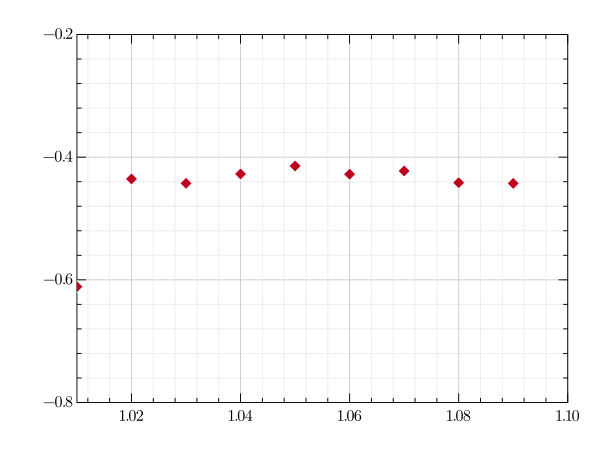

In [47]:
#plot
using GR
x = 1.01:0.01:1.1
xlim([1.01, 1.1])
ylim([-0.8, -0.2])
for i = 1:1:10
    r = 1.0 + 0.01 * i
    y = real(e[i])
    println("r = $r ,energy = $y")
end
plot(x, real(e),"red")